In [0]:
pip install surprise

     |████████████████████████████████| 6.5MB 2.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678234 sha256=ffe29b7cfc9a61421402b99a1070dd54ba3657d4bd22f140d1f86c6c8fc8ec96
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
# import packages
import numpy as np 
import pandas as pd 
import os 
from matplotlib import pyplot as plt
import warnings
import time
from scipy.sparse import coo_matrix
warnings.filterwarnings('ignore')

from surprise.dataset import Dataset
from surprise.similarities import pearson
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import BaselineOnly

from surprise import Reader
from surprise.model_selection.split import KFold, train_test_split
from surprise.accuracy import mse, rmse
from sklearn import metrics

In [0]:
#data_directory = r'/Users/rover/Desktop/2020 Winter/ECE 219/Project 3/ml-latest-small'
#os.chdir(data_directory)

# links = pd.read_csv('links.csv')
# movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv') # only movie rating is used in this project
tags = pd.read_csv('tags.csv') # used for movie genre

### MovieLens dataset

$\textbf{Question 1}$: Compute the sparsity of the movie rating dataset, where spar- sity is defined by equation 1 
Sparsity = Total number of available ratings / Total number of possible ratings

In [0]:
# create rating matrix R
matrix = coo_matrix((ratings.rating.to_list(), (ratings.userId.to_list(), ratings.movieId.to_list()))).toarray()
R = pd.DataFrame(index = range(611), columns= ratings['movieId'].unique(), data = matrix[:, ratings.movieId.unique()])
R = R.drop(R.index[0])
R.replace(0, np.nan, inplace = True)

# compute sparcity
num_movie = len(ratings['movieId'].unique())
num_user = len(ratings['userId'].unique())
sparcity = 1 - R.isna().sum().sum()/(num_movie * num_user)
print('The sparsity index of the rating matrix is %.4f'%sparcity)

The sparsity index of the rating matrix is 0.0170


$\textbf{Question 2}$: Plot a histogram showing the frequency of the rating values. To be specific, bin the rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R with rating values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram


The lowest rating is 0.5000
The highest rating is 5.0000
The median rating is 3.5000
The mean rating is 3.5016


Text(0, 0.5, 'Frequency')

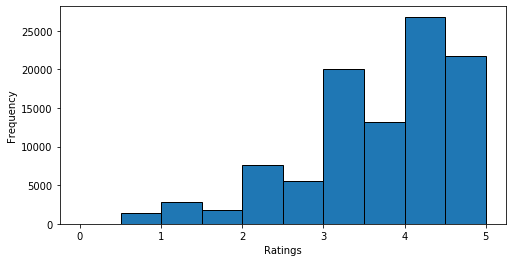

In [0]:
print('The lowest rating is %.4f'%min(ratings['rating']))
print('The highest rating is %.4f'%max(ratings['rating']))
print('The median rating is %.4f'%np.median(ratings['rating']))
print('The mean rating is %.4f'%np.mean(ratings['rating']))

fig, ax = plt.subplots(figsize = (8,4))
ax.hist(ratings['rating'], bins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], edgecolor='black')
ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency')

$\textbf{Question 3}$: Plot the distribution of the number of ratings received among movies. To be specific, the X-axis should be the movie index ordered by de- creasing frequency and the Y -axis should be the number of ratings the movie has received. For example, the movie that has the largest number of ratings has index 1; ties can broken in any way. A monotonically decreasing curve instead of a histogram is expected.

Text(0, 0.5, 'number of ratings')

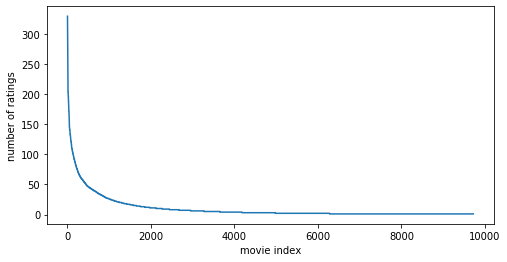

In [0]:
# count the number of ratings for each movie
movie_rate_frequency = pd.DataFrame(index = ratings.movieId.unique(), data = num_user - R.isna().sum(axis = 0))
movie_rate_frequency = movie_rate_frequency.sort_values(by = 0, ascending=False)

fig, ax = plt.subplots(figsize = (8,4))
ax.plot(list(range(num_movie)), movie_rate_frequency[0])
ax.set_xlabel('movie index')
ax.set_ylabel('number of ratings')

$\textbf{Question 4}$: Plot the distribution of ratings among users. To be specific, the X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user have rated. The requirement of the
2 plot is similar to that in Question 3.

Text(0, 0.5, 'number of ratings')

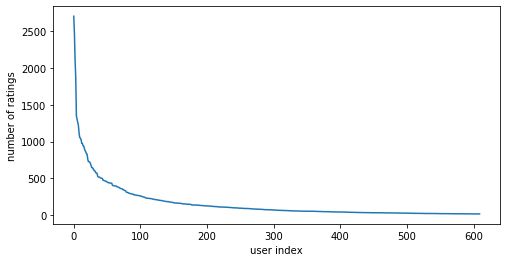

In [0]:
# count the number of ratings for each user
user_rate_frequency = pd.DataFrame(index = ratings.userId.unique(), data = num_movie - R.isna().sum(axis = 1))
user_rate_frequency = user_rate_frequency.sort_values(by = 0, ascending=False)

fig, ax = plt.subplots(figsize = (8,4))
ax.plot(list(range(num_user)), user_rate_frequency[0])
ax.set_xlabel('user index')
ax.set_ylabel('number of ratings')

$\textbf{Question 5}$: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

Among all movies, only small proportional of movies receive more than 1 ratings. Most of the movies only be rated by 1 user. 

$\textbf{Question 6}$: Compute the variance of the rating values received by each movie. Then, bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram

Text(0, 0.5, 'frequency')

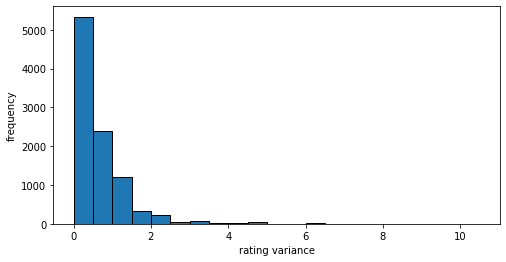

In [0]:
# compute the rating variance of each movie
movie_rate_var = pd.DataFrame(index = ratings.movieId.unique(), data = R.var(axis = 0))
movie_rate_var.replace(np.nan, 0, inplace = True)

fig, ax = plt.subplots(figsize = (8,4))
ax.hist(movie_rate_var[0], bins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5],edgecolor='black')
ax.set_xlabel('rating variance')
ax.set_ylabel('frequency')

### Neighborhood-based collaborative filtering

#### Pearson-correlation coefficient

$\textbf{Question 7}$: Write down the formula for μu in terms of Iu and ruk

$\mu_u = \frac{1}{|I_u|}\sum_{i \in I_u} r_{ui}$, where $|I_u|$ is the number of elements in $I_u$

$\textbf{Question 8}$: In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅

$I_u \land I_v$ refers to the movies that have been rated by both user $u$ and $v$. $I_u \land I_v$ can be $\phi$, which present user $u$ and $v$ don't have a rated movie in common. This is the main reason that the rating matrix is sparcity.

$\textbf{Question 9}$ Can you explain the reason behind mean-centering the raw ratings in the prediction function?

#### k-NN collaborative filter

In [0]:
# prepare data
file_path = os.path.expanduser(r'ratings.csv')
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0, 5), skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

# prepare trimmed movieId
movie_frevar = pd.DataFrame(index = ratings.movieId.unique())
movie_frevar['frequency'] = num_user - R.isna().sum(axis = 0)
movie_frevar['variance'] = R.var(axis = 0)
popular_movieId = movie_rate_frequency[movie_frevar['frequency'] > 2].index.tolist()
popular_movieId = list(map(str, popular_movieId))

unpopular_movieId = movie_rate_frequency[movie_frevar['frequency'] <= 2].index.tolist()
unpopular_movieId = list(map(str, unpopular_movieId))

highvar_movieId = movie_rate_frequency[(movie_frevar['frequency'] >= 5) & (movie_frevar['variance'] >= 2)].index.tolist()
highvar_movieId = list(map(str, highvar_movieId))

In [0]:
class knn_baseline_kfold():
    def __init__(self, n_neighbor, similarity_option, data):
        self.model = knns.KNNBaseline(k = n_neighbor, sim_options = similarity_option)
        self.data = data

    def cross_validation(self, n_folds, trim_flag = False, trim_list = None):
        # define k-fold cross validation
        kf = KFold(n_splits = n_folds)

        # define results dict and list
        results_cache = {}
        rmse_score, mse_score = [], []

        # perform k-fold and store the results
        for train, test in kf.split(self.data):
            self.model.fit(train)

            if trim_flag:
                test = self.trim(test, trim_list)

            # if the trimmed test set is empty, jump to next k-fold
            if len(test) == 0:
                continue 

            preds = self.model.test(test)
            rmse_score.append(rmse(preds))
            mse_score.append(mse(preds))

        results_cache['mean_rmse'], results_cache['mean_mse'], results_cache['rmse_hist'], results_cache['mse_hist'] = np.mean(rmse_score[rmse_score!=0]), np.mean(mse_score[mse_score!=0]), rmse_score, mse_score
        return results_cache

    def trim(self, testset, movieId_list):
        '''
        testset: list, testing data that needed to be trimmed
        trim_list: list, movieId that satisfy the trim requeirement 
        '''
        temp_df = pd.DataFrame(columns = ['userId', 'movieId', 'rate'], data = testset)
        temp = temp_df[temp_df['movieId'].isin(movieId_list)]
        
        return temp.values.tolist()

In [0]:
# prepare data
file_path = os.path.expanduser(r'ratings.csv')
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0, 5), skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

$\textbf{Question 10}$ : Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).


In [0]:
# define number of neighbors
K = np.arange(2, 102, 2)

# define results recorder 
mean_rmse_10, mean_mae_10 = [], []

# perform k-fold cross-validation 
sim_opt = {'name': 'pearson_baseline', 'user_based': False}

for k in K:
    model = knn_baseline_kfold(n_neighbor = k, similarity_option = sim_opt, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = False)
    mean_rmse_10.append(performance['mean_rmse'])
    mean_mae_10.append(performance['mean_mse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9484
MSE: 0.8996
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9573
MSE: 0.9163
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9751
MSE: 0.9509
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9485
MSE: 0.8997
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9529
MSE: 0.9080
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9432
MSE: 0.8896
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9708
MSE: 0.9425
Estima

0.8436020724352454
0.711664456617041


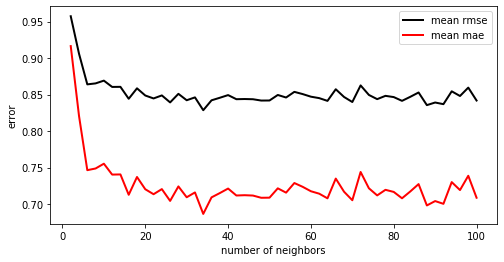

In [0]:
print(mean_rmse_10[20])
print(mean_mae_10[20])
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_10, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_10, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 11}:$ Use the plot from question 10, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE


k = 20, mse = 0.7157, rmse = 0.8460

$\textbf{Question 12}:$ Design a k-NN collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [0]:
# define number of neighbors
K = np.arange(2, 102, 2)

# define results recorder 
mean_rmse_12, mean_mae_12 = [], []

# perform k-fold cross-validation 
sim_opt = {'name': 'pearson_baseline', 'user_based': False}

for k in K:
    model = knn_baseline_kfold(n_neighbor = k, similarity_option = sim_opt, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = popular_movieId)
    mean_rmse_12.append(performance['mean_rmse'])
    mean_mae_12.append(performance['mean_mse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9529
MSE: 0.9081
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9496
MSE: 0.9018
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9652
MSE: 0.9316
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9500
MSE: 0.9026
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9697
MSE: 0.9402
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9526
MSE: 0.9074
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9522
MSE: 0.9066
Estima

0.8313634239181131
0.6911651426288483


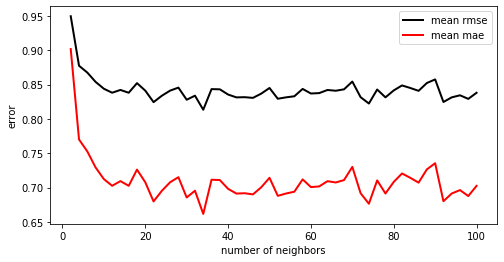

In [0]:
print(mean_rmse_12[20])
print(mean_mae_12[20])
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_12, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_12, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 13}:$ Design a k-NN collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [0]:
# define number of neighbors
K = np.arange(2, 102, 2)

# define results recorder 
mean_rmse_13, mean_mae_13 = [], []

# perform k-fold cross-validation 
sim_opt = {'name': 'pearson_baseline', 'user_based': False}

for k in K:
    model = knn_baseline_kfold(n_neighbor = k, similarity_option = sim_opt, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = unpopular_movieId)
    mean_rmse_13.append(performance['mean_rmse'])
    mean_mae_13.append(performance['mean_mse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9900
MSE: 0.9802
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9385
MSE: 0.8808
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9777
MSE: 0.9559
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0091
MSE: 1.0183
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9351
MSE: 0.8744
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9530
MSE: 0.9082
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9948
MSE: 0.9897
Estima

0.9014628900387499
0.8126353421170153


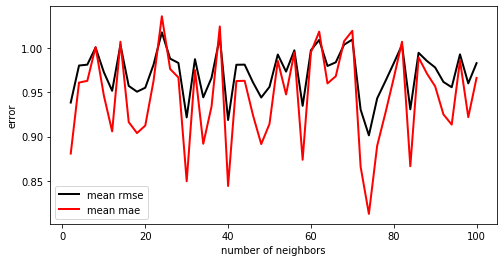

In [0]:
print(min(mean_rmse_13))
print(min(mean_mae_13))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_13, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_13, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 14}:$ Design a k-NN collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s perfor- mance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE


In [0]:
# define number of neighbors
K = np.arange(2, 102, 2)

# define results recorder 
mean_rmse_14, mean_mae_14 = [], []

# perform k-fold cross-validation 
sim_opt = {'name': 'pearson_baseline', 'user_based': False}

for k in K:
    model = knn_baseline_kfold(n_neighbor = k, similarity_option = sim_opt, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = highvar_movieId)
    mean_rmse_14.append(performance['mean_rmse'])
    mean_mae_14.append(performance['mean_mse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.3884
MSE: 1.9276
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.6308
MSE: 2.6595
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.7525
MSE: 3.0713
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.5335
MSE: 2.3516
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.4294
MSE: 2.0433
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.3025
MSE: 1.6966
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.3451
MSE: 1.8092
Estima

1.3872684603573442
1.9365102489538355


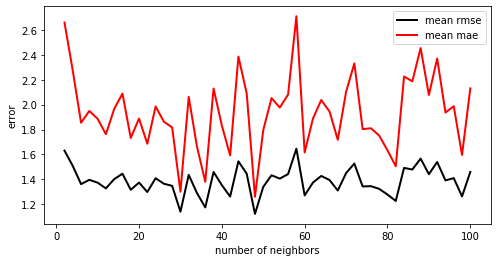

In [0]:
print(np.mean(mean_rmse_14))
print(np.mean(mean_mae_14))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_14, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_14, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 15}:$ Plot the ROC curves for the k-NN collaborative filter designed in question 10 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the curve (AUC) value.

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
The roc areas of the 4 thresholds are [0.8071771363933951, 0.787741919670092, 0.7871680867308565, 0.7899004020747654] , respectively


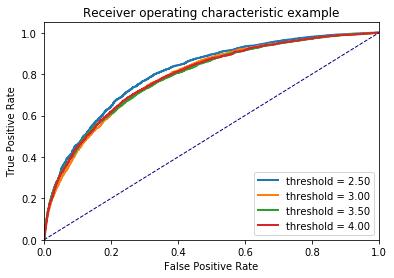

In [0]:
# use k = 20 from problem 10
model_15 = knns.KNNBaseline(k = 20, sim_options = sim_opt)
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = True)
model_15.fit(data_train)
test_pred = model_15.test(data_test)

# make ROC plot
true_test_rating = [data_test[p][2] for p in range(len(data_test))]
pred_test_rating = [test_pred[p][3] for p in range(len(test_pred))]
threshold = [2.5, 3, 3.5, 4]
fprs, tprs = [], []
roc_auc = []
for t in threshold:
    true_test_bi = np.array(true_test_rating) > t
    fpr, tpr, _ = metrics.roc_curve(true_test_bi, pred_test_rating)
    roc_auc.append(metrics.auc(fpr, tpr))
    fprs.append(fpr)
    tprs.append(tpr)

for i in range(4):
    plt.plot(fprs[i], tprs[i], lw=2, label = 'threshold = %.2f'%threshold[i])

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
print('The roc areas of the 4 thresholds are', roc_auc, ', respectively')

$\textbf{Question 16}$: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.